# Prediction of Solar Power Genetation 

Dacon Competition 태양광 발전량 예측



In [50]:
import pandas as pd
import numpy as np
import os
import glob
import random

import warnings
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score

%matplotlib inline
warnings.filterwarnings("ignore")
PATH="/content/drive/MyDrive/data/"

Pinball loss 함수

In [ ]:
def smape(true, pred,i):
  if len(true)==len(pred):
    s = true - pred
    return np.where(s>=0,(s)*i,(s*-1)*(1-i)).reshape(-1,1)

## 데이터 전처리

data pre-processing

### train 데이터 전처리

get train data

In [2]:
train= pd.read_csv(PATH+"train/train.csv")


기본적으로 주어지는 columns
-  Hour - 시간
-  Minute - 분
-  DHI - 수평면 산란일사량(Diffuse Horizontal Irradiance (W/m2))
-  DNI - 직달일사량(Direct Normal Irradiance (W/m2))
-  WS - 풍속(Wind Speed (m/s))
-  RH - 상대습도(Relative Humidity (%))
-  T - 기온(Temperature (Degree C))
-  Target - 태양광 발전량 (kW)

In [22]:
train.head()

,Day,Hour,Minute,DHI,DNI,WS,RH,T,TARGET
0,0,0,0,0,0,1.5,69.08,-12,0.0
1,0,0,30,0,0,1.5,69.06,-12,0.0
2,0,1,0,0,0,1.6,71.78,-12,0.0
3,0,1,30,0,0,1.6,71.75,-12,0.0
4,0,2,0,0,0,1.6,75.20,-12,0.0


##### train 데이터에 태양고도 대입

train에 12월 25일부터 날짜 대입
및 월 입력
  
  본래 데이터는 1월 1일부터 시작하는 것으로 보임,
      
  하지만 동지와 하지를 기준으로 1년이 돌아가도록 동지를 12월 15일로 맞춤(본래는 12월 21일) 

In [3]:
s1 = "train = train.reset_index(drop = True)"
tt1=pd.date_range('2020-12-25 00:30',periods=(52560)/2,freq='H')
tt2=pd.date_range('2020-12-25 00:00',periods=(52560)/2,freq='H')
tt=pd.concat([pd.DataFrame({'Date':tt1}),pd.DataFrame({'Date':tt2})])
tt = tt.sort_values('Date')
tt = np.array(tt).reshape(-1)    
tt=pd.DataFrame({'Date':tt})
s2 = "train_time = pd.concat([train,tt],axis=1)"
  #s2 = "test_%d['Date']==tt"%(i)
exec(s1)
exec(s2)
train_time['month']=train_time['Date'].dt.month

**각 월에 값에 태양의 위치(지구의 공전)를 1~7로 분류해서 대입**
    train_time['Sun'] 

- 예) 12월 => 1, (1월, 11월) => 2,....,6월 => 7

In [4]:
def Get_Sun(train_time):
  return np.where(np.array(train_time['month'])==12,1,
                            np.where(np.array(train_time['month'])==1,2,
                                      np.where(np.array(train_time['month'])==2,3,
                                              np.where(np.array(train_time['month'])==3,4,
                                                        np.where(np.array(train_time['month'])==4,5,
                                                                np.where(np.array(train_time['month'])==5,6,
                                                                          np.where(np.array(train_time['month'])==6,7,
                                                                np.where(np.array(train_time['month'])==7,6,
                                                        np.where(np.array(train_time['month'])==8,5,
                                              np.where(np.array(train_time['month'])==9,4,
                                      np.where(np.array(train_time['month'])==10,3,2)))))))))))

In [5]:
train_time['Sun']=Get_Sun(train_time)

##### train 전처리 함수

- 기본적으로 BaseLine을 따름
- 특이점은 train 데이터에는 Sun 값을 넣었고 Test데이터에는 Sun값을 안넣었음
- Test 데이터의 Sun 값은 예측 후 대입 할 예정




- 베이스 라인 과 다른 점

  - 지난 2,3,5,6일간의 평균값 추가
  - 2일전 값 추가
  - 일출, 일몰 시간 추가
  - 시간에 따른 태양 고도와 GHI추가



In [6]:
def create_lag_feats(data, lags, cols):
    
    lag_cols = []
    temp = data.copy()
    for col in cols:
        for lag in lags:
            temp[col + '_lag_%s'%lag] = temp[col].shift(lag)
            
            
            temp['Target1'] = temp['TARGET']
            temp['Target2'] = temp['TARGET'].shift(-48).fillna(method='ffill')  
            lag_cols.append(col + '_lag_%s'%lag)
            #3일간의 TARGET, DNI, DHI, RH, T, WS의 평균값
            temp['Target_mean3'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill')+ temp['TARGET'].shift(48*3).fillna(method='ffill') ) /3
            temp['DHI_mean3'] = (temp['DHI'].shift(48).fillna(method='ffill') +temp['DHI'].shift(48*2).fillna(method='ffill')+ temp['DHI'].shift(48*3).fillna(method='ffill') ) /3
            temp['DNI_mean3'] = (temp['DNI'].shift(48).fillna(method='ffill') +temp['DNI'].shift(48*2).fillna(method='ffill')+ temp['DNI'].shift(48*3).fillna(method='ffill') ) /3
            temp['RH_mean3'] = (temp['RH'].shift(48).fillna(method='ffill') +temp['RH'].shift(48*2).fillna(method='ffill')+ temp['RH'].shift(48*3).fillna(method='ffill') ) /3
            temp['T_mean3'] = (temp['T'].shift(48).fillna(method='ffill') +temp['T'].shift(48*2).fillna(method='ffill')+ temp['T'].shift(48*3).fillna(method='ffill') ) /3
            temp['WS_mean3'] = (temp['WS'].shift(48).fillna(method='ffill') +temp['WS'].shift(48*2).fillna(method='ffill')+ temp['WS'].shift(48*3).fillna(method='ffill') ) /3
            
            #5일간의 TARGET, DNI, DHI, RH, T, WS의 평균값
            temp['Target_mean'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill')+ temp['TARGET'].shift(48*3).fillna(method='ffill') + temp['TARGET'].shift(48*4).fillna(method='ffill') + temp['TARGET'].shift(48*5).fillna(method='ffill')) /5
            temp['DHI_mean'] = (temp['DHI'].shift(48).fillna(method='ffill') +temp['DHI'].shift(48*2).fillna(method='ffill')+ temp['DHI'].shift(48*3).fillna(method='ffill') + temp['DHI'].shift(48*4).fillna(method='ffill') + temp['DHI'].shift(48*5).fillna(method='ffill')) /5
            temp['DNI_mean'] = (temp['DNI'].shift(48).fillna(method='ffill') +temp['DNI'].shift(48*2).fillna(method='ffill')+ temp['DNI'].shift(48*3).fillna(method='ffill') + temp['DNI'].shift(48*4).fillna(method='ffill')+ temp['DNI'].shift(48*5).fillna(method='ffill')) /5
            temp['RH_mean'] = (temp['RH'].shift(48).fillna(method='ffill') +temp['RH'].shift(48*2).fillna(method='ffill')+ temp['RH'].shift(48*3).fillna(method='ffill') + temp['RH'].shift(48*4).fillna(method='ffill')+ temp['RH'].shift(48*5).fillna(method='ffill')) /5
            temp['T_mean'] = (temp['T'].shift(48).fillna(method='ffill') +temp['T'].shift(48*2).fillna(method='ffill')+ temp['T'].shift(48*3).fillna(method='ffill') + temp['T'].shift(48*4).fillna(method='ffill')  + temp['T'].shift(48*5).fillna(method='ffill')) /5
            temp['WS_mean'] = (temp['WS'].shift(48).fillna(method='ffill') +temp['WS'].shift(48*2).fillna(method='ffill')+ temp['WS'].shift(48*3).fillna(method='ffill') + temp['WS'].shift(48*4).fillna(method='ffill')  + temp['WS'].shift(48*5).fillna(method='ffill')) /5
            
            #6일간의 TARGET, DNI, DHI, RH, T, WS의 평균값
            temp['Target_mean6'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill')+ temp['TARGET'].shift(48*3).fillna(method='ffill') + temp['TARGET'].shift(48*4).fillna(method='ffill') + temp['TARGET'].shift(48*5).fillna(method='ffill')+ temp['TARGET'].shift(48*5).fillna(method='ffill')) /6
            temp['DHI_mean6'] = (temp['DHI'].shift(48).fillna(method='ffill') +temp['DHI'].shift(48*2).fillna(method='ffill')+ temp['DHI'].shift(48*3).fillna(method='ffill') + temp['DHI'].shift(48*4).fillna(method='ffill') + temp['DHI'].shift(48*5).fillna(method='ffill')+ temp['DHI'].shift(48*5).fillna(method='ffill')) /6
            temp['DNI_mean6'] = (temp['DNI'].shift(48).fillna(method='ffill') +temp['DNI'].shift(48*2).fillna(method='ffill')+ temp['DNI'].shift(48*3).fillna(method='ffill') + temp['DNI'].shift(48*4).fillna(method='ffill')+ temp['DNI'].shift(48*5).fillna(method='ffill')+ temp['DNI'].shift(48*5).fillna(method='ffill')) /6
            temp['RH_mean6'] = (temp['RH'].shift(48).fillna(method='ffill') +temp['RH'].shift(48*2).fillna(method='ffill')+ temp['RH'].shift(48*3).fillna(method='ffill') + temp['RH'].shift(48*4).fillna(method='ffill')+ temp['RH'].shift(48*5).fillna(method='ffill')+ temp['RH'].shift(48*5).fillna(method='ffill')) /6
            temp['T_mean6'] = (temp['T'].shift(48).fillna(method='ffill') +temp['T'].shift(48*2).fillna(method='ffill')+ temp['T'].shift(48*3).fillna(method='ffill') + temp['T'].shift(48*4).fillna(method='ffill')  + temp['T'].shift(48*5).fillna(method='ffill')+ temp['T'].shift(48*5).fillna(method='ffill')) /6
            temp['WS_mean6'] = (temp['WS'].shift(48).fillna(method='ffill') +temp['WS'].shift(48*2).fillna(method='ffill')+ temp['WS'].shift(48*3).fillna(method='ffill') + temp['WS'].shift(48*4).fillna(method='ffill')  + temp['WS'].shift(48*5).fillna(method='ffill') + temp['WS'].shift(48*5).fillna(method='ffill')) /6
            
            # 2일간의 값 차이
            temp['Target_diff'] = (temp['TARGET'].shift(48).fillna(method='ffill') +temp['TARGET'].shift(48*2).fillna(method='ffill'))-(temp['TARGET'].shift(48*3).fillna(method='ffill') + temp['TARGET'].shift(48*4).fillna(method='ffill'))
            temp['DHI_diff'] = (temp['DHI'].shift(48).fillna(method='ffill') +temp['DHI'].shift(48*2).fillna(method='ffill'))-(temp['DHI'].shift(48*3).fillna(method='ffill') + temp['DHI'].shift(48*4).fillna(method='ffill'))
            temp['DNI_diff'] = (temp['DNI'].shift(48).fillna(method='ffill') +temp['DNI'].shift(48*2).fillna(method='ffill'))-(temp['DNI'].shift(48*3).fillna(method='ffill') + temp['DNI'].shift(48*4).fillna(method='ffill'))
            temp['RH_diff'] = (temp['RH'].shift(48).fillna(method='ffill') +temp['RH'].shift(48*2).fillna(method='ffill'))-(temp['RH'].shift(48*3).fillna(method='ffill') + temp['RH'].shift(48*4).fillna(method='ffill'))
            temp['T_diff'] = (temp['T'].shift(48).fillna(method='ffill') +temp['T'].shift(48*2).fillna(method='ffill'))-(temp['T'].shift(48*3).fillna(method='ffill') + temp['T'].shift(48*4).fillna(method='ffill'))
            
            # 전날 값
            temp['Target_yester'] = temp['TARGET'].shift(96).fillna(method='ffill')
            temp['DHI_yester'] = temp['DHI'].shift(96).fillna(method='ffill')
            temp['DNI_yester'] = temp['DNI'].shift(96).fillna(method='ffill')
            temp['T_yester'] = temp['T'].shift(96).fillna(method='ffill')
            temp['RH_yester'] = temp['RH'].shift(96).fillna(method='ffill')
            temp['WS_yester'] = temp['WS'].shift(96).fillna(method='ffill')
    return temp, lag_cols
    

def preprocess_data(data, target_lags=[48], weather_lags=[48], is_train=True):
    
    temp = data.copy()

    if is_train==True:          
    
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI','DHI_mean', 'DNI','DNI_mean','Sun','WS','WS_mean', 'RH',  'RH_mean','T','T_mean','Target_mean','Target_mean6','DHI_mean6','DNI_mean6','RH_mean6','WS_mean6','T_mean6','Target_mean3','DHI_mean3','DNI_mean3','RH_mean3','WS_mean3','T_mean3','Target_diff','DHI_diff','DNI_diff','RH_diff','T_diff','Target_yester','DHI_yester','DNI_yester','T_yester','RH_yester','WS_yester'])
     
        return temp[['Hour']+['Minute'] + temp_lag_cols1 + temp_lag_cols2 + ['Target1', 'Target2']].dropna()

    elif is_train==False:    
        
        temp, temp_lag_cols1 = create_lag_feats(temp, target_lags, ['TARGET'])
        temp, temp_lag_cols2 = create_lag_feats(temp, weather_lags, ['DHI','DHI_mean', 'DNI','DNI_mean','WS','WS_mean', 'RH',  'RH_mean','T','T_mean','Target_mean','Target_mean6','DHI_mean6','DNI_mean6','RH_mean6','WS_mean6','T_mean6','Target_mean3','DHI_mean3','DNI_mean3','RH_mean3','WS_mean3','T_mean3','Target_diff','DHI_diff','DNI_diff','RH_diff','T_diff','Target_yester','DHI_yester','DNI_yester','T_yester','RH_yester','WS_yester'])
                              
        return temp[['Hour']+['Minute']  + temp_lag_cols1 + temp_lag_cols2].dropna()



In [23]:
df_train = preprocess_data(train_time, target_lags=[48], weather_lags=[48], is_train=True)
df_training=df_train.copy()
df_training.head()

,Hour,Minute,TARGET_lag_48,DHI_lag_48,DHI_mean_lag_48,DNI_lag_48,DNI_mean_lag_48,Sun_lag_48,WS_lag_48,WS_mean_lag_48,RH_lag_48,RH_mean_lag_48,T_lag_48,T_mean_lag_48,Target_mean_lag_48,Target_mean6_lag_48,DHI_mean6_lag_48,DNI_mean6_lag_48,RH_mean6_lag_48,WS_mean6_lag_48,T_mean6_lag_48,Target_mean3_lag_48,DHI_mean3_lag_48,DNI_mean3_lag_48,RH_mean3_lag_48,WS_mean3_lag_48,T_mean3_lag_48,Target_diff_lag_48,DHI_diff_lag_48,DNI_diff_lag_48,RH_diff_lag_48,T_diff_lag_48,Target_yester_lag_48,DHI_yester_lag_48,DNI_yester_lag_48,T_yester_lag_48,RH_yester_lag_48,WS_yester_lag_48,Target1,Target2
288,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,1.84,77.41,76.680,1.0,-9.8,0.0,0.0,0.0,0.0,75.413333,1.783333,-10.166667,0.0,0.0,0.0,74.553333,2.033333,-9.000000,0.0,0.0,0.0,-14.60,-1.0,0.0,0.0,0.0,-14.0,77.76,1.8,0.0,0.0
289,0,30,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.84,77.42,75.562,1.0,-9.6,0.0,0.0,0.0,0.0,74.478333,1.783333,-10.000000,0.0,0.0,0.0,72.690000,2.033333,-8.666667,0.0,0.0,0.0,-9.01,0.0,0.0,0.0,0.0,-13.0,77.77,2.0,0.0,0.0
290,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.9,1.90,76.77,75.756,1.0,-9.8,0.0,0.0,0.0,0.0,75.093333,1.850000,-10.166667,0.0,0.0,0.0,72.963333,2.100000,-8.666667,0.0,0.0,0.0,-7.34,1.0,0.0,0.0,0.0,-13.0,77.69,2.2,0.0,0.0
291,1,30,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.90,76.77,74.516,1.0,-9.8,0.0,0.0,0.0,0.0,74.055000,1.850000,-10.166667,0.0,0.0,0.0,70.906667,2.100000,-8.666667,0.0,0.0,0.0,-13.47,1.0,0.0,0.0,0.0,-13.0,71.57,2.2,0.0,0.0
292,2,0,0.0,0.0,0.0,0.0,0.0,1.0,2.2,1.92,76.39,76.198,1.0,-9.8,0.0,0.0,0.0,0.0,76.031667,1.866667,-10.166667,0.0,0.0,0.0,71.646667,2.133333,-8.666667,0.0,0.0,0.0,-14.67,1.0,0.0,0.0,0.0,-13.0,72.62,2.2,0.0,0.0


In [24]:
import math
# 각도를 pi값으로 변환
degree=lambda x:x*math.pi/180

해뜨는 시간 지는 시간 계산 함수 (30분 단위)

In [25]:
def Get_Sunuptime(df_s):#해 뜨는 시간 
  l=[]
  df_sun=pd.concat([df_s],axis=0,ignore_index=True)
  for i in np.array(df_sun[df_sun['Hour']==13].index).reshape(-1,2)[:,0]:
    if df_sun.iloc[i-16]['TARGET_lag_48']>0:l.append(10)
    elif df_sun.iloc[i-15]['TARGET_lag_48']>0:l.append(11)
    elif df_sun.iloc[i-14]['TARGET_lag_48']>0:l.append(12)
    elif df_sun.iloc[i-13]['TARGET_lag_48']>0:l.append(13)
    elif df_sun.iloc[i-12]['TARGET_lag_48']>0:l.append(14)
    elif df_sun.iloc[i-11]['TARGET_lag_48']>0:l.append(15)
    elif df_sun.iloc[i-10]['TARGET_lag_48']>0:l.append(16)
  return np.array(l).repeat(48).reshape(-1,1)

def Get_Sundowntime(df_s): #해 지는 시간
  l=[]
  df_sun=pd.concat([df_s],axis=0,ignore_index=True)
  for i in np.array(df_sun[df_sun['Hour']==13].index).reshape(-1,2)[:,0]:
    if df_sun.iloc[i+10]['TARGET_lag_48']==0:l.append(34)
    elif df_sun.iloc[i+11]['TARGET_lag_48']==0:l.append(35)
    elif df_sun.iloc[i+12]['TARGET_lag_48']==0:l.append(36)
    elif df_sun.iloc[i+13]['TARGET_lag_48']==0:l.append(37)
    elif df_sun.iloc[i+14]['TARGET_lag_48']==0:l.append(38)
    elif df_sun.iloc[i+15]['TARGET_lag_48']==0:l.append(39)
    elif df_sun.iloc[i+16]['TARGET_lag_48']==0:l.append(40)
  return np.array(l).repeat(48).reshape(-1,1)

In [26]:
df_training['Sun_Up']=Get_Sunuptime(df_training)
df_training['Sun_Down']=Get_Sundowntime(df_training)

##### 태양고도와 그에 따른 GHI 대입과 상대습도 분류
1. Sun 값에 해당하는 태양 남중고도의 도를 라디안으로 변환하여 ['Sun_Top_degree']에 저장 
    
    - 예) Sun 값 1 => 15.1 => 15.1 Ⅹ π/180 , Sun 값 2 => 22.9 => 22.9  Ⅹ π/180
2. 시간별로 태양고도값 대입 

3. 각 데이터의 GHI를 구함
    - GHI = DHI + DNI Ⅹ cos(70-Θ), Θ: 태양고도

태양위치에 따른 태양의 남중고도 대입(대략적임)



In [27]:
def Get_South_Sun_degree(df_training):
  return np.where(np.array(df_training['Sun_lag_48'])==1,degree(15.1),
          np.where(np.array(df_training['Sun_lag_48'])==2,degree(22.9),
                    np.where(np.array(df_training['Sun_lag_48'])==3,degree(30.7),
                            np.where(np.array(df_training['Sun_lag_48'])==4,degree(38.5),
                                      np.where(np.array(df_training['Sun_lag_48'])==5,degree(46.3),
                                              np.where(np.array(df_training['Sun_lag_48'])==6,degree(53.6),degree(61.4))))))).round(4).reshape(-1,1)


In [28]:
df_training['Sun_Top_degree']=Get_South_Sun_degree(df_training)

**남중고도와 시간(30분 단위)에 따른 태양의 고도 대입**

In [29]:
def Get_New_Sundegree(df):
  return np.where(df['Sun_lag_48']==1,
         np.where( df['Hour']<17,np.where(df['Hour']>=7 , 
                                          np.where( df['Hour']<=12 , np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/5.5, df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/5.5 ), 
                                                  np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/4.5, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/4.5 )),0),0),
np.where(df['Sun_lag_48']==2,
         np.where( df['Hour']<18,np.where(df['Hour']>=7,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/6 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/6 ),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/5, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/5)),0),0), 
np.where(df['Sun_lag_48']==3,
         np.where( df['Hour']<18,np.where(df['Hour']>=6,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/6.5 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/6.5 ),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/5.5, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/5.5)),0),0),
np.where(df['Sun_lag_48']==4,
         np.where( df['Hour']<19,np.where(df['Hour']>=6,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/7 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/7 ),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/6, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/6)),0),0),
np.where(df['Sun_lag_48']==5,
         np.where( df['Hour']<19,np.where(df['Hour']>=5,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/7.5 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/7.5 ),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/6.5, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/6.5)),0),0),          
np.where(df['Sun_lag_48']==6,
         np.where( df['Hour']<20,np.where(df['Hour']>=5,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/8 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/8),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/7, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/7)),0),0),  
np.where(df['Sun_lag_48']==7,
         np.where( df['Hour']<20,np.where(df['Hour']>=4,
                                          np.where( df['Hour']<=12, np.where(df['Minute']==0,df['Sun_Top_degree']-(12.5-df['Hour'])*df['Sun_Top_degree']/8.5 ,  df['Sun_Top_degree']-(12-df['Hour'])*df['Sun_Top_degree']/8.5),
                                                   np.where(df['Minute']==0,df['Sun_Top_degree']-(df['Hour']-12.5)*df['Sun_Top_degree']/7.5, df['Sun_Top_degree']-(df['Hour']-12)*df['Sun_Top_degree']/7.5)),0),0),  
0))))))).reshape(-1,1)

태양고도와 DNI, DHI를 이용하여 GHI를 구함

In [30]:
df_training['Sun_degree']=Get_New_Sundegree(df_training)
df_training['GHI_lag_48']=df_training['DHI_lag_48']+df_training['DNI_lag_48']*np.cos(degree(70)-df_training['Sun_degree'])
df_training['GHI_mean_lag_48']=df_training['DHI_mean_lag_48']+df_training['DNI_mean_lag_48']*np.cos(degree(70)-df_training['Sun_degree'])
df_training['GHI_yester_lag_48']=df_training['DHI_yester_lag_48']+df_training['DNI_yester_lag_48']*np.cos(degree(70)-df_training['Sun_degree'])
df_training['GHI_mean6_lag_48']=df_training['DHI_mean6_lag_48']+df_training['DNI_mean6_lag_48']*np.cos(degree(70)-df_training['Sun_degree'])
df_training['GHI_mean3_lag_48']=df_training['DHI_mean3_lag_48']+df_training['DNI_mean3_lag_48']*np.cos(degree(70)-df_training['Sun_degree'])

상대습도 등급 표시 95이상 10 70이상 5 나머지 0

In [31]:
df_training['Rain_lag_48']=np.where(df_training['RH_lag_48']>=95,10,np.where(df_training['RH_lag_48']>=70,5,0))

##### 팀원 Leekee's 아이디어 GHI/(T*WS)

In [32]:
df_training['LK_lag_48']=df_training['GHI_lag_48']/((30+df_training['T_lag_48'])*df_training['WS_lag_48'])
df_training['LK_mean_lag_48']=df_training['GHI_mean_lag_48']/((30+df_training['T_mean_lag_48'])*df_training['WS_mean_lag_48'])
df_training['LK_yester_lag_48']=df_training['GHI_yester_lag_48']/((30+df_training['T_yester_lag_48'])*df_training['WS_yester_lag_48'])
df_training['LK_mean6_lag_48']=df_training['GHI_mean6_lag_48']/((30+df_training['T_mean6_lag_48'])*df_training['WS_mean6_lag_48'])
df_training['LK_mean3_lag_48']=df_training['GHI_mean3_lag_48']/((30+df_training['T_mean3_lag_48'])*df_training['WS_mean3_lag_48'])

In [34]:
df_training.head()

,Hour,Minute,TARGET_lag_48,DHI_lag_48,DHI_mean_lag_48,DNI_lag_48,DNI_mean_lag_48,Sun_lag_48,WS_lag_48,WS_mean_lag_48,RH_lag_48,RH_mean_lag_48,T_lag_48,T_mean_lag_48,Target_mean_lag_48,Target_mean6_lag_48,DHI_mean6_lag_48,DNI_mean6_lag_48,RH_mean6_lag_48,WS_mean6_lag_48,T_mean6_lag_48,Target_mean3_lag_48,DHI_mean3_lag_48,DNI_mean3_lag_48,RH_mean3_lag_48,WS_mean3_lag_48,T_mean3_lag_48,Target_diff_lag_48,DHI_diff_lag_48,DNI_diff_lag_48,RH_diff_lag_48,T_diff_lag_48,Target_yester_lag_48,DHI_yester_lag_48,DNI_yester_lag_48,T_yester_lag_48,RH_yester_lag_48,WS_yester_lag_48,Target1,Target2,Sun_Up,Sun_Down,Sun_Top_degree,Sun_degree,GHI_lag_48,GHI_mean_lag_48,GHI_yester_lag_48,GHI_mean6_lag_48,GHI_mean3_lag_48,Rain_lag_48,LK_lag_48,LK_mean_lag_48,LK_yester_lag_48,LK_mean6_lag_48,LK_mean3_lag_48
288,0,0,0.0,0.0,0.0,0.0,0.0,1.0,1.5,1.84,77.41,76.680,1.0,-9.8,0.0,0.0,0.0,0.0,75.413333,1.783333,-10.166667,0.0,0.0,0.0,74.553333,2.033333,-9.000000,0.0,0.0,0.0,-14.60,-1.0,0.0,0.0,0.0,-14.0,77.76,1.8,0.0,0.0,16,34,0.2635,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0
289,0,30,0.0,0.0,0.0,0.0,0.0,1.0,1.7,1.84,77.42,75.562,1.0,-9.6,0.0,0.0,0.0,0.0,74.478333,1.783333,-10.000000,0.0,0.0,0.0,72.690000,2.033333,-8.666667,0.0,0.0,0.0,-9.01,0.0,0.0,0.0,0.0,-13.0,77.77,2.0,0.0,0.0,16,34,0.2635,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0
290,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.9,1.90,76.77,75.756,1.0,-9.8,0.0,0.0,0.0,0.0,75.093333,1.850000,-10.166667,0.0,0.0,0.0,72.963333,2.100000,-8.666667,0.0,0.0,0.0,-7.34,1.0,0.0,0.0,0.0,-13.0,77.69,2.2,0.0,0.0,16,34,0.2635,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0
291,1,30,0.0,0.0,0.0,0.0,0.0,1.0,2.0,1.90,76.77,74.516,1.0,-9.8,0.0,0.0,0.0,0.0,74.055000,1.850000,-10.166667,0.0,0.0,0.0,70.906667,2.100000,-8.666667,0.0,0.0,0.0,-13.47,1.0,0.0,0.0,0.0,-13.0,71.57,2.2,0.0,0.0,16,34,0.2635,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0
292,2,0,0.0,0.0,0.0,0.0,0.0,1.0,2.2,1.92,76.39,76.198,1.0,-9.8,0.0,0.0,0.0,0.0,76.031667,1.866667,-10.166667,0.0,0.0,0.0,71.646667,2.133333,-8.666667,0.0,0.0,0.0,-14.67,1.0,0.0,0.0,0.0,-13.0,72.62,2.2,0.0,0.0,16,34,0.2635,0.0,0.0,0.0,0.0,0.0,0.0,5,0.0,0.0,0.0,0.0,0.0


### Test 데이터 전처리

#### Test데이터 태양 고도 예측

태양 고도 예측용으로 훈련세트 테스트 세트 분리

In [38]:

Xs=df_training[df_training['Hour']==13][['TARGET_lag_48', 'DHI_lag_48', 'DHI_mean_lag_48',
       'DNI_lag_48', 'DNI_mean_lag_48',  'WS_lag_48',
       'WS_mean_lag_48', 'RH_lag_48', 'RH_mean_lag_48', 'T_lag_48',
       'T_mean_lag_48', 'Target_mean_lag_48', 'Target_mean6_lag_48',
       'DHI_mean6_lag_48', 'DNI_mean6_lag_48', 'RH_mean6_lag_48',
       'WS_mean6_lag_48', 'T_mean6_lag_48','Target_mean3_lag_48',
       'DHI_mean3_lag_48', 'DNI_mean3_lag_48', 'RH_mean3_lag_48',
       'WS_mean3_lag_48', 'T_mean3_lag_48', 'Sun_Up',
       'Sun_Down','Target_yester_lag_48', 'DHI_yester_lag_48', 'DNI_yester_lag_48',
       'T_yester_lag_48', 'RH_yester_lag_48', 'Rain_lag_48']]
Ys=df_training[df_training['Hour']==13]['Sun_lag_48']
X_train_m, X_valid_m, Y_train_m, Y_valid_m = train_test_split(Xs,Ys, test_size=0.4, random_state=0)

태양 고도 예측 모델 XGB

In [36]:
xgb=XGBClassifier(n_estimators=1000,boosting = 'dart', learning_rate = 0.01, max_depth = 7,early_stopping_rounds = 300, 
                eval_metric='error', eval_set=[(X_valid_m,Y_valid_m)] )
xgb.fit(X_train_m,Y_train_m, verbose=100)
xgb.score(X_valid_m,Y_valid_m)

0.8990825688073395

태양 고도 예측 모델 LGBM

In [39]:

lgb = LGBMClassifier(object = 'multiclass',
                     n_estimators=600,
                     learning_late=0.001,
                     subsample=0.7)

lgb.fit(X_train_m, Y_train_m, eval_metric = 'error', 
          eval_set=[(X_valid_m, Y_valid_m)], early_stopping_rounds=300,verbose=100)
lgb.score(X_valid_m,Y_valid_m)

Training until validation scores don't improve for 300 rounds.
[100]	valid_0's multi_error: 0.0802752	valid_0's multi_logloss: 0.203543
[200]	valid_0's multi_error: 0.0768349	valid_0's multi_logloss: 0.237671
[300]	valid_0's multi_error: 0.0779817	valid_0's multi_logloss: 0.269492
[400]	valid_0's multi_error: 0.0779817	valid_0's multi_logloss: 0.282632
Early stopping, best iteration is:
[100]	valid_0's multi_error: 0.0802752	valid_0's multi_logloss: 0.203543


0.9197247706422018

태양 고도 예측 모델 RF

In [41]:
forest=RandomForestClassifier(n_estimators=700,random_state=0)
forest.fit(X_train_m, Y_train_m)
forest.score(X_valid_m,Y_valid_m)

0.9002293577981652

#### 모델용 데이터 전처리

기존 데이터 전처리 함수사용 + 각 Test데이터 마지막 날의 13시 데이터를 이용하여  태양고도 예측 후 그에 따른 GHI를 구하여 대입




In [47]:
df_test = []
f=[] #RF Classification
x=[] #LGBM Classification
p1=pd.DataFrame(np.zeros(48*9).reshape(-1,9),columns=['Day', 'Hour', 'Minute', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET'])
p1['Hour']=np.arange(0,24).repeat(2).reshape(-1,1)
p1['Day']=np.array(-1).repeat(48).reshape(-1,1)
p1['Minute']=np.array([0,30]*24).reshape(-1,1)
p7=pd.DataFrame(np.zeros(48*9).reshape(-1,9),columns=['Day', 'Hour', 'Minute', 'DHI', 'DNI', 'WS', 'RH', 'T', 'TARGET'])
p7['Hour']=np.arange(0,24).repeat(2).reshape(-1,1)
p7['Day']=np.array(7).repeat(48).reshape(-1,1)
p7['Minute']=np.array([0,30]*24).reshape(-1,1)
for i in range(81):
    file_path = PATH+'test/' + str(i) + '.csv'
    temp = pd.read_csv(file_path)
    target1= temp['TARGET'][-48:]
    temp = pd.concat([temp,p7])
    temp = preprocess_data(temp, target_lags=[48], weather_lags=[48], is_train=False).iloc[-48:]
    temp['Sun_Up']=Get_Sunuptime(temp)
    temp['Sun_Down']=Get_Sundowntime(temp)
    temp['Rain_lag_48']=np.where(temp['RH_lag_48']>=95,10,np.where(temp['RH_lag_48']>=70,5,0))
    z=temp[temp['Hour']==13][['TARGET_lag_48', 'DHI_lag_48', 'DHI_mean_lag_48',
       'DNI_lag_48', 'DNI_mean_lag_48',  'WS_lag_48',
       'WS_mean_lag_48', 'RH_lag_48', 'RH_mean_lag_48', 'T_lag_48',
       'T_mean_lag_48', 'Target_mean_lag_48', 'Target_mean6_lag_48',
       'DHI_mean6_lag_48', 'DNI_mean6_lag_48', 'RH_mean6_lag_48',
       'WS_mean6_lag_48', 'T_mean6_lag_48','Target_mean3_lag_48',
       'DHI_mean3_lag_48', 'DNI_mean3_lag_48', 'RH_mean3_lag_48',
       'WS_mean3_lag_48', 'T_mean3_lag_48', 'Sun_Up',
       'Sun_Down','Target_yester_lag_48', 'DHI_yester_lag_48', 'DNI_yester_lag_48',
       'T_yester_lag_48', 'RH_yester_lag_48', 'Rain_lag_48']]
    temp['Sun_lag_48']=(np.zeros(48)+lgb.predict(z)[0]).reshape(-1,1)
    f.append(forest.predict(z)[0])
    x.append(lgb.predict(z)[0])
    temp['Sun_Top_degree']=Get_South_Sun_degree(temp)
    temp['Sun_degree']=Get_New_Sundegree(temp)
    temp['GHI_yester_lag_48']=temp['DHI_yester_lag_48']+temp['DNI_yester_lag_48']*np.cos(degree(70)-temp['Sun_degree'])
    temp['GHI_lag_48']=temp['DHI_lag_48']+temp['DNI_lag_48']*np.cos(degree(70)-temp['Sun_degree'])
    temp['GHI_mean_lag_48']=temp['DHI_mean_lag_48']+temp['DNI_mean_lag_48']*np.cos(degree(70)-temp['Sun_degree'])
    temp['GHI_mean6_lag_48']=temp['DHI_mean6_lag_48']+temp['DNI_mean6_lag_48']*np.cos(degree(70)-temp['Sun_degree'])
    temp['GHI_mean3_lag_48']=temp['DHI_mean3_lag_48']+temp['DNI_mean3_lag_48']*np.cos(degree(70)-temp['Sun_degree'])
    temp['LK_lag_48']=temp['GHI_lag_48']/((30+temp['T_lag_48'])*temp['WS_lag_48'])
    temp['LK_mean_lag_48']=temp['GHI_mean_lag_48']/((30+temp['T_mean_lag_48'])*temp['WS_mean_lag_48'])
    temp['LK_yester_lag_48']=temp['GHI_yester_lag_48']/((30+temp['T_yester_lag_48'])*temp['WS_yester_lag_48'])
    temp['LK_mean6_lag_48']=temp['GHI_mean6_lag_48']/((30+temp['T_mean6_lag_48'])*temp['WS_mean6_lag_48'])
    temp['LK_mean3_lag_48']=temp['GHI_mean3_lag_48']/((30+temp['T_mean3_lag_48'])*temp['WS_mean3_lag_48'])
    df_test.append(temp)
    

X_test = pd.concat(df_test)
X_test.shape #test Data

(3888, 53)

In [51]:
print(f'{accuracy_score(f, x) * 100:.4f}%')  #LGBM 와 RANDOMFOREST 예측이 얼마나 다른지 표시

83.9506%


In [52]:
X_test.head()

,Hour,Minute,TARGET_lag_48,DHI_lag_48,DHI_mean_lag_48,DNI_lag_48,DNI_mean_lag_48,WS_lag_48,WS_mean_lag_48,RH_lag_48,RH_mean_lag_48,T_lag_48,T_mean_lag_48,Target_mean_lag_48,Target_mean6_lag_48,DHI_mean6_lag_48,DNI_mean6_lag_48,RH_mean6_lag_48,WS_mean6_lag_48,T_mean6_lag_48,Target_mean3_lag_48,DHI_mean3_lag_48,DNI_mean3_lag_48,RH_mean3_lag_48,WS_mean3_lag_48,T_mean3_lag_48,Target_diff_lag_48,DHI_diff_lag_48,DNI_diff_lag_48,RH_diff_lag_48,T_diff_lag_48,Target_yester_lag_48,DHI_yester_lag_48,DNI_yester_lag_48,T_yester_lag_48,RH_yester_lag_48,WS_yester_lag_48,Sun_Up,Sun_Down,Rain_lag_48,Sun_lag_48,Sun_Top_degree,Sun_degree,GHI_yester_lag_48,GHI_lag_48,GHI_mean_lag_48,GHI_mean6_lag_48,GHI_mean3_lag_48,LK_lag_48,LK_mean_lag_48,LK_yester_lag_48,LK_mean6_lag_48,LK_mean3_lag_48
0,0,0,0.0,0.0,0.0,0.0,0.0,0.8,1.72,80.92,47.274,-2.8,-0.72,0.0,0.0,0.0,0.0,43.883333,1.716667,-1.480297e-16,0.0,0.0,0.0,56.390000,1.866667,-3.433333,0.0,0.0,0.0,10.72,-13.6,0.0,0.0,0.0,-6.0,57.25,2.4,15,34,5,2.0,0.3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,30,0.0,0.0,0.0,0.0,0.0,0.9,1.72,81.53,48.112,-2.9,-0.94,0.0,0.0,0.0,0.0,44.613333,1.716667,-2.000000e-01,0.0,0.0,0.0,57.630000,1.866667,-3.733333,0.0,0.0,0.0,9.94,-13.4,0.0,0.0,0.0,-6.0,57.25,2.4,15,34,5,2.0,0.3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,1.72,79.91,48.414,-3.0,-1.14,0.0,0.0,0.0,0.0,45.011667,1.716667,-3.833333e-01,0.0,0.0,0.0,57.933333,1.900000,-4.000000,0.0,0.0,0.0,2.01,-13.3,0.0,0.0,0.0,-6.1,55.26,2.5,15,34,5,2.0,0.3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,30,0.0,0.0,0.0,0.0,0.0,0.9,1.72,79.91,48.810,-3.0,-1.26,0.0,0.0,0.0,0.0,45.408333,1.716667,-5.166667e-01,0.0,0.0,0.0,58.363333,1.900000,-4.100000,0.0,0.0,0.0,2.05,-13.3,0.0,0.0,0.0,-6.1,55.26,2.5,15,34,5,2.0,0.3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2,0,0.0,0.0,0.0,0.0,0.0,0.9,1.74,77.20,49.784,-3.0,-1.38,0.0,0.0,0.0,0.0,46.575000,1.733333,-6.500000e-01,0.0,0.0,0.0,58.860000,1.933333,-4.166667,0.0,0.0,0.0,-4.63,-13.1,0.0,0.0,0.0,-6.0,54.25,2.6,15,34,5,2.0,0.3997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 모델 학습

model learning

### 훈련세트 테스트 세트 나누기 

  split train set, test set

  
  0_train_1 : 1일전 날씨와 당일 발전량   
  0_train_2 : 1일전 날씨와 다음날 발전량 



In [55]:
df_model_train=df_training[['Hour', 'Minute', 'TARGET_lag_48', 'DHI_lag_48', 'DHI_mean_lag_48',
       'DNI_lag_48', 'DNI_mean_lag_48', 'Sun_lag_48', 'WS_lag_48',
       'WS_mean_lag_48', 'RH_lag_48', 'RH_mean_lag_48', 'T_lag_48',
       'T_mean_lag_48', 'Target_mean_lag_48', 'Target_mean6_lag_48',
       'DHI_mean6_lag_48', 'DNI_mean6_lag_48', 'RH_mean6_lag_48',
       'WS_mean6_lag_48', 'T_mean6_lag_48', 'Target_mean3_lag_48',
       'DHI_mean3_lag_48', 'DNI_mean3_lag_48', 'RH_mean3_lag_48',
       'WS_mean3_lag_48', 'T_mean3_lag_48', 'Target_diff_lag_48',
       'DHI_diff_lag_48', 'DNI_diff_lag_48', 'RH_diff_lag_48', 'T_diff_lag_48',
       'Target_yester_lag_48', 'DHI_yester_lag_48', 'DNI_yester_lag_48',
       'T_yester_lag_48', 'RH_yester_lag_48',  'Sun_Up',
       'Sun_Down', 'Sun_Top_degree', 'Sun_degree', 'GHI_lag_48',
       'GHI_mean_lag_48', 'GHI_yester_lag_48', 'GHI_mean6_lag_48',
       'GHI_mean3_lag_48', 'Rain_lag_48',
       'LK_lag_48', 'LK_mean_lag_48', 'LK_yester_lag_48', 'LK_mean6_lag_48',
       'LK_mean3_lag_48', 'Target1', 'Target2']]
X_testc=X_test[['Hour', 'Minute', 'TARGET_lag_48', 'DHI_lag_48', 'DHI_mean_lag_48',
       'DNI_lag_48', 'DNI_mean_lag_48', 'Sun_lag_48', 'WS_lag_48',
       'WS_mean_lag_48', 'RH_lag_48', 'RH_mean_lag_48', 'T_lag_48',
       'T_mean_lag_48', 'Target_mean_lag_48', 'Target_mean6_lag_48',
       'DHI_mean6_lag_48', 'DNI_mean6_lag_48', 'RH_mean6_lag_48',
       'WS_mean6_lag_48', 'T_mean6_lag_48', 'Target_mean3_lag_48',
       'DHI_mean3_lag_48', 'DNI_mean3_lag_48', 'RH_mean3_lag_48',
       'WS_mean3_lag_48', 'T_mean3_lag_48', 'Target_diff_lag_48',
       'DHI_diff_lag_48', 'DNI_diff_lag_48', 'RH_diff_lag_48', 'T_diff_lag_48',
       'Target_yester_lag_48', 'DHI_yester_lag_48', 'DNI_yester_lag_48',
       'T_yester_lag_48', 'RH_yester_lag_48',  'Sun_Up',
       'Sun_Down', 'Sun_Top_degree', 'Sun_degree', 'GHI_lag_48',
       'GHI_mean_lag_48', 'GHI_yester_lag_48', 'GHI_mean6_lag_48',
       'GHI_mean3_lag_48', 'Rain_lag_48',
       'LK_lag_48', 'LK_mean_lag_48', 'LK_yester_lag_48', 'LK_mean6_lag_48',
       'LK_mean3_lag_48']]

In [57]:
X_train_1, X_valid_1, Y_train_1, Y_valid_1 = train_test_split(df_model_train.iloc[:, :-2], df_model_train.iloc[:, -2], test_size=0.4, random_state=0)
X_train_2, X_valid_2, Y_train_2, Y_valid_2 = train_test_split(df_model_train.iloc[:, :-2], df_model_train.iloc[:, -1], test_size=0.4, random_state=0)


In [58]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

### 학습

Learning

####LGBM regressor 사용 

Target 예측

In [59]:
from lightgbm import LGBMRegressor
def LGBM( X_train, Y_train, X_valid, Y_valid, X_test,q):
    # (a) Modeling  
    model = LGBMRegressor(objective='quantile', alpha=q,colsample_bytree=.8,n_estimators=200000, bagging_fraction=0.7, learning_rate=0.001, subsample=0.7)   
      #LGBMRegressor(objective='quantile', alpha=q,min_child_samples=20,colsample_bytree=.8,n_estimators=100000, bagging_fraction=0.7, learning_rate=0.001, subsample=0.7)                   
                          
                          
    model.fit(X_train, Y_train, eval_metric = ['quantile'], 
            eval_set=[(X_valid, Y_valid)], early_stopping_rounds=100, verbose=10000)
    
      # (b) Predictions
    pred = pd.Series(model.predict(X_test).round(2))
    return pred, model
def train_data(X_train, Y_train, X_valid, Y_valid, X_test):

    LGBM_models=[]
    LGBM_actual_pred = pd.DataFrame()

    for q in quantiles:
        print(q)
        pred , model = LGBM( X_train, Y_train, X_valid, Y_valid, X_test,q)
        LGBM_models.append(model)
        LGBM_actual_pred = pd.concat([LGBM_actual_pred,pred],axis=1)

    LGBM_actual_pred.columns=quantiles
    
    return LGBM_models, LGBM_actual_pred

당일 TARGET예측

In [ ]:
# Target1
models_1, results_1 = train_data(X_train_1, Y_train_1, X_valid_1, Y_valid_1, X_testc)
results_1=pd.DataFrame(np.sort(results_1, axis=1))
results_1[:48]

0.1
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 1.34265
Early stopping, best iteration is:
[12956]	valid_0's quantile: 1.33979
0.2
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.07547
[20000]	valid_0's quantile: 2.02704
Early stopping, best iteration is:
[25443]	valid_0's quantile: 2.01433
0.3
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.44201
[20000]	valid_0's quantile: 2.3632
[30000]	valid_0's quantile: 2.31681
[40000]	valid_0's quantile: 2.29628
Early stopping, best iteration is:
[43437]	valid_0's quantile: 2.29428
0.4
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.55262
[20000]	valid_0's quantile: 2.46906
[30000]	valid_0's quantile: 2.41806
[40000]	valid_0's quantile: 2.38549
[50000]	valid_0's quantile: 2.3626
[60000]	valid_0's quantile: 2.3444
[70000]	valid_0's quantile: 2.33342
[80000]	valid_0's 

,0,1,2,3,4,5,6,7,8
0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


다음날 Target 예측

In [ ]:
models_2, results_2 = train_data(X_train_2, Y_train_2, X_valid_2, Y_valid_2, X_testc)
results_2=pd.DataFrame(np.sort(results_2, axis=1))
results_2.sort_index()[:48]

0.1
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 1.38351
Early stopping, best iteration is:
[10072]	valid_0's quantile: 1.3835
0.2
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.17078
[20000]	valid_0's quantile: 2.12883
Early stopping, best iteration is:
[28752]	valid_0's quantile: 2.11465
0.3
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.52887
[20000]	valid_0's quantile: 2.44153
[30000]	valid_0's quantile: 2.39521
[40000]	valid_0's quantile: 2.36543
[50000]	valid_0's quantile: 2.34849
[60000]	valid_0's quantile: 2.33941
[70000]	valid_0's quantile: 2.32454
[80000]	valid_0's quantile: 2.31261
[90000]	valid_0's quantile: 2.30545
Early stopping, best iteration is:
[91000]	valid_0's quantile: 2.30506
0.4
Training until validation scores don't improve for 100 rounds.
[10000]	valid_0's quantile: 2.66659
[20000]	valid_0's quantile: 2.56609
Early stopping, 

,0,1,2,3,4,5,6,7,8
0,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
1,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
2,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
3,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,-0.00,0.00
4,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
5,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
8,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00
9,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00


In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
submission.loc[submission.id.str.contains("Day7"), "q_0.1":] = np.where(results_1.sort_index().values>=0,results_1.sort_index().values,0)
submission.loc[submission.id.str.contains("Day8"), "q_0.1":] = np.where(results_2.sort_index().values>=0,results_2.sort_index().values,0)

####N-fold CV

In [ ]:


trn_1 =df_model_train.iloc[:, :-2]
y_1 = df_model_train.iloc[:, -2]
trn_2 =df_model_train.iloc[:, :-2]
y_2 = df_model_train.iloc[:, -1]
X_testCV=X_testc
cv = KFold(n_splits=5,shuffle = True ,random_state=0)


In [ ]:

kk=0
for i,(i_trn, i_val) in enumerate(cv.split(trn_1, y_1), 1):
    print(f'training model for CV #{i}')
    print(i_trn)
    models_1, results_1 = train_data(trn_1.iloc[i_trn],
                                     y_1.iloc[i_trn],
                                     trn_1.iloc[i_val],
                                     y_1.iloc[i_val],
                                     X_testCV)
    
    s1="sub%d = pd.read_csv(PATH+'sample_submission.csv')"%(kk)
    s2="sub%d.loc[sub%d.id.str.contains('Day7'), 'q_0.1':] = np.where(results_1.sort_index().values>=0,results_1.sort_index().values,0)"%(kk,kk)
    exec(s1)
    exec(s2)
    kk+=1

training model for CV #1
[    0     2     4 ... 52221 52222 52223]
0.1
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's quantile: 1.63383
[1000]	valid_0's quantile: 1.51831
[1500]	valid_0's quantile: 1.45293
[2000]	valid_0's quantile: 1.41463
[2500]	valid_0's quantile: 1.39252
[3000]	valid_0's quantile: 1.37693
[3500]	valid_0's quantile: 1.36773
[4000]	valid_0's quantile: 1.36069
[4500]	valid_0's quantile: 1.35609
[5000]	valid_0's quantile: 1.35203
[5500]	valid_0's quantile: 1.34907
[6000]	valid_0's quantile: 1.34596
[6500]	valid_0's quantile: 1.34329
[7000]	valid_0's quantile: 1.34113
[7500]	valid_0's quantile: 1.3392
[8000]	valid_0's quantile: 1.33758
[8500]	valid_0's quantile: 1.33633
[9000]	valid_0's quantile: 1.33481
[9500]	valid_0's quantile: 1.33381
[10000]	valid_0's quantile: 1.33267
[10500]	valid_0's quantile: 1.33152
[11000]	valid_0's quantile: 1.33034
[11500]	valid_0's quantile: 1.32949
[12000]	valid_0's quantile: 1.32872
[12500]	valid_0's quant

In [ ]:
kk=0
for i,(i_trn, i_val) in enumerate(cv.split(trn_2, y_2), 1):
    print(f'training model for CV #{i}')
    print(i_trn)
    models_1, results_1 = train_data(trn_2.iloc[i_trn],
                                     y_2.iloc[i_trn],
                                     trn_2.iloc[i_val],
                                     y_2.iloc[i_val],
                                     X_testCV)
    
    s2="sub%d.loc[sub%d.id.str.contains('Day8'), 'q_0.1':] = np.where(results_1.sort_index().values>=0,results_1.sort_index().values,0)"%(kk,kk)
    exec(s1)
    exec(s2)
    kk+=1


training model for CV #1
[    0     2     4 ... 52221 52222 52223]
0.1
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's quantile: 1.64098
[1000]	valid_0's quantile: 1.53681
[1500]	valid_0's quantile: 1.48841
[2000]	valid_0's quantile: 1.46296
[2500]	valid_0's quantile: 1.44838
[3000]	valid_0's quantile: 1.4377
[3500]	valid_0's quantile: 1.43157
[4000]	valid_0's quantile: 1.42868
[4500]	valid_0's quantile: 1.42746
Early stopping, best iteration is:
[4791]	valid_0's quantile: 1.42745
0.2
Training until validation scores don't improve for 100 rounds.
[500]	valid_0's quantile: 2.99788
[1000]	valid_0's quantile: 2.67146
[1500]	valid_0's quantile: 2.50095
[2000]	valid_0's quantile: 2.40218
[2500]	valid_0's quantile: 2.34765
[3000]	valid_0's quantile: 2.31404
[3500]	valid_0's quantile: 2.28765
[4000]	valid_0's quantile: 2.26604
[4500]	valid_0's quantile: 2.25229
[5000]	valid_0's quantile: 2.2423
[5500]	valid_0's quantile: 2.23297
[6000]	valid_0's quantile: 2.2226

In [ ]:
sub_1=((np.array(sub0.iloc[:,1:])+np.array(sub1.iloc[:,1:])+np.array(sub2.iloc[:,1:])+np.array(sub3.iloc[:,1:])+np.array(sub4.iloc[:,1:]))/5)

In [ ]:
submission_CV = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')


submission_CV.loc[:, 'q_0.1':] = np.where(sub_1>=0.009,sub_1,0)

In [ ]:
submission_CV = pd.read_csv('/content/drive/MyDrive/data/sample_submission.csv')
submission_CV.loc[:, 'q_0.1':] = np.where(sub_1>=0.009,sub_1,0)

### 결과

In [ ]:
from datetime import datetime, timedelta
RESULT_FILE_NAME=(datetime.now()+timedelta(hours=9)).strftime('%y%m%d-%H%M%S_KTH.csv')
RESULT_FILE_NAME

'210126-162743_KTH.csv'

In [ ]:
submission.to_csv(PATH+RESULT_FILE_NAME,index=False)

(-0.3, 100.0)

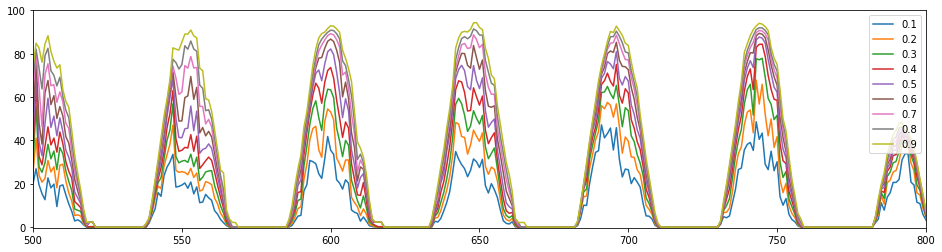

In [ ]:
plt.figure(figsize=(16,4))
for i in quantiles:
  plt.plot(np.arange(0,7776),submission["q_"+str(i)],label=str(i))
plt.legend()
plt.xlim(500,800)
plt.ylim(-0.3,100)